In [5]:
import pandas as pd
import numpy as np
# import matplotlib.pyplot as plt
# import yfinance as yf

# from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
# from sklearn.linear_model import LinearRegression, Ridge, Lasso
# from sklearn.ensemble import RandomForestRegressor
# from xgboost import XGBRegressor
# from sklearn.metrics import mean_squared_error, r2_score
# from sklearn.preprocessing import StandardScaler

# Load Data
data = pd.read_csv("D:\Data\TCS_stock_history.csv") 
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values(by='Date', inplace=True)

# Convert numeric columns
for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
    data[col] = pd.to_numeric(data[col], errors='coerce')

data.fillna(method='ffill', inplace=True)

# Feature Engineering
data['Prev_Close'] = data['Close'].shift(1)
data['MA50'] = data['Close'].rolling(50).mean()
data['MA200'] = data['Close'].rolling(200).mean()
data['Day'] = data['Date'].dt.day
data['Month'] = data['Date'].dt.month
data['Day_of_Week'] = data['Date'].dt.dayofweek

data.dropna(inplace=True)

<>:14: SyntaxWarning: invalid escape sequence '\D'
<>:14: SyntaxWarning: invalid escape sequence '\D'
C:\Users\MUDIT\AppData\Local\Temp\ipykernel_4364\4094492654.py:14: SyntaxWarning: invalid escape sequence '\D'
  data = pd.read_csv("D:\Data\TCS_stock_history.csv")
C:\Users\MUDIT\AppData\Local\Temp\ipykernel_4364\4094492654.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [6]:
data.head()


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Prev_Close,MA50,MA200,Day,Month,Day_of_Week
199,2004-06-21,66.919920,68.407029,64.540547,65.451401,49328,0.0,0.0,66.157806,53.539858,38.361673,21,6,0
200,2004-06-22,65.432855,65.618744,63.573967,63.927155,20064,0.0,0.0,65.451401,54.208315,38.533714,22,6,1
201,2004-06-23,64.596334,65.061056,61.584935,62.681683,22912,0.0,0.0,63.927155,54.837176,38.701525,23,6,2
202,2004-06-24,63.192893,64.317518,61.919554,63.722672,21592,0.0,0.0,62.681683,55.496152,38.884579,24,6,3
203,2004-06-25,63.202185,65.061073,63.202185,63.722672,60280,0.0,0.0,63.722672,56.147134,39.067632,25,6,4


In [ ]:
# Features & Target
X = data[['Open', 'High', 'Low', 'Volume', 'Prev_Close', 'MA50', 'MA200', 'Day_of_Week', 'Month']]
y = data['Close']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Time Series Cross Validation
tscv = TimeSeriesSplit(n_splits=5)

# ---------------- Linear Regression CV ----------------
lr = LinearRegression()
lr_scores = []

for train_idx, test_idx in tscv.split(X_scaled):
    lr.fit(X_scaled[train_idx], y.iloc[train_idx])
    pred = lr.predict(X_scaled[test_idx])
    lr_scores.append(r2_score(y.iloc[test_idx], pred))

print("Linear Regression CV R² Score:", np.mean(lr_scores))


# ---------------- Random Forest with Hyperparameter Tuning ----------------
rfr = RandomForestRegressor(random_state=42)

rf_params = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_search = RandomizedSearchCV(rfr, rf_params, cv=tscv, n_iter=10, n_jobs=-1, scoring='r2', random_state=42)
rf_search.fit(X_scaled, y)

best_rf = rf_search.best_estimator_
print("\nBest RandomForest Params:", rf_search.best_params_)

# Evaluate RF
rf_scores = []
for train_idx, test_idx in tscv.split(X_scaled):
    best_rf.fit(X_scaled[train_idx], y.iloc[train_idx])
    pred = best_rf.predict(X_scaled[test_idx])
    rf_scores.append(r2_score(y.iloc[test_idx], pred))

print("RandomForest CV R² Score:", np.mean(rf_scores))


# ---------------- XGBoost Model with Tuning ----------------
from xgboost import XGBRegressor

xgb = XGBRegressor(random_state=42)

xgb_params = {
    'n_estimators': [100, 200, 400],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 6, 10],
    'subsample': [0.6, 0.8, 1]
}

xgb_search = RandomizedSearchCV(xgb, xgb_params, cv=tscv, n_iter=10, n_jobs=-1, scoring='r2', random_state=42)
xgb_search.fit(X_scaled, y)

best_xgb = xgb_search.best_estimator_
print("\nBest XGBoost Params:", xgb_search.best_params_)

xgb_scores = []
for train_idx, test_idx in tscv.split(X_scaled):
    best_xgb.fit(X_scaled[train_idx], y.iloc[train_idx])
    pred = best_xgb.predict(X_scaled[test_idx])
    xgb_scores.append(r2_score(y.iloc[test_idx], pred))

print("XGBoost CV R² Score:", np.mean(xgb_scores))


# ---------------- Final Prediction Plot ----------------
train_idx, test_idx = list(tscv.split(X_scaled))[-1]
best_xgb.fit(X_scaled[train_idx], y.iloc[train_idx])
final_pred = best_xgb.predict(X_scaled[test_idx])

plt.figure(figsize=(10,5))
plt.plot(y.iloc[test_idx].values, label="Actual Price")
plt.plot(final_pred, label="Predicted Price")
plt.title("TCS Stock Price - Actual vs Predicted")
plt.legend()
plt.show()


# ---------------- Live Price Fetch ----------------
ticker = "TCS.NS"
tcs = yf.Ticker(ticker)
current_price = tcs.history(period="1d")["Close"].iloc[-1]
print(f"\nCurrent TCS Live Price: ₹{current_price:.2f}")

<>:14: SyntaxWarning: invalid escape sequence '\D'
<>:14: SyntaxWarning: invalid escape sequence '\D'
C:\Users\MUDIT\AppData\Local\Temp\ipykernel_4364\3807227948.py:14: SyntaxWarning: invalid escape sequence '\D'
  data = pd.read_csv("D:\Data\TCS_stock_history.csv")
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x000002625DC49BE0>>
Traceback (most recent call last):
  File "C:\Users\MUDIT\AppData\Local\Programs\Python\Python313\Lib\site-packages\ipykernel\ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
C:\Users\MUDIT\AppData\Local\Temp\ipykernel_4364\3807227948.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


Linear Regression CV R² Score: 0.998667225915946



KeyboardInterrupt


KeyboardInterrupt



In [1]:
data.head()


NameError: name 'data' is not defined

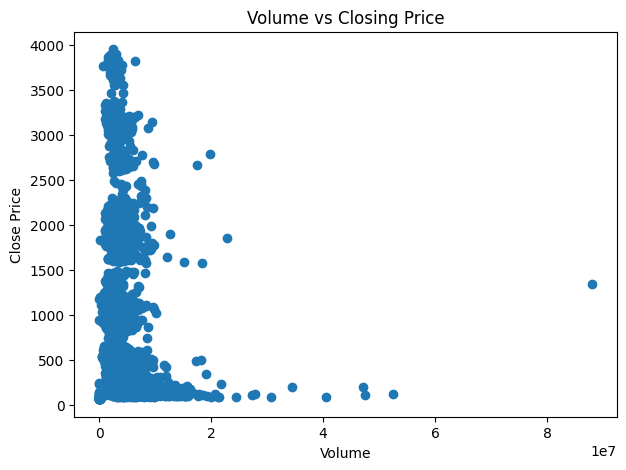

In [14]:
#Volume vs Close Price Scatter
plt.figure(figsize=(7,5))
plt.scatter(data['Volume'], data['Close'])
plt.title("Volume vs Closing Price")
plt.xlabel("Volume")
plt.ylabel("Close Price")
plt.show()


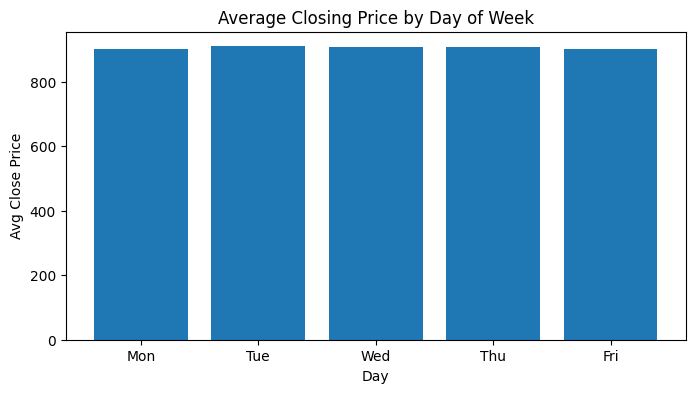

In [15]:
#Day-of-Week Trend
dow_avg = data.groupby('Day_of_Week')['Close'].mean()

plt.figure(figsize=(8,4))
plt.bar(['Mon','Tue','Wed','Thu','Fri'], dow_avg)
plt.title("Average Closing Price by Day of Week")
plt.xlabel("Day")
plt.ylabel("Avg Close Price")
plt.show()


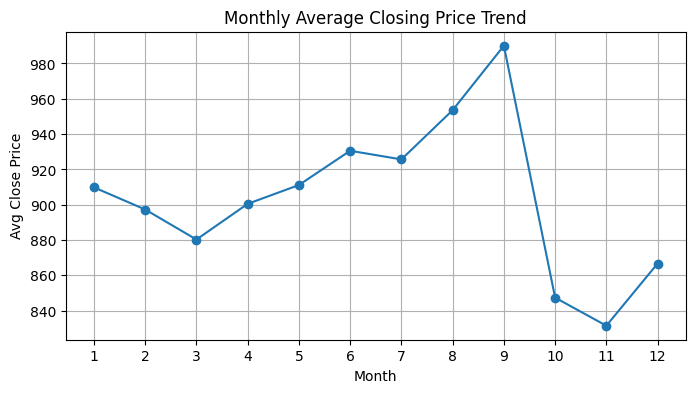

In [16]:
#Monthly Average Closing Price Trend
monthly_avg = data.groupby('Month')['Close'].mean()

plt.figure(figsize=(8,4))
plt.plot(monthly_avg.index, monthly_avg.values, marker='o')
plt.xticks(range(1,13))
plt.xlabel("Month")
plt.ylabel("Avg Close Price")
plt.title("Monthly Average Closing Price Trend")
plt.grid(True)
plt.show()



📈 Future 7-Day TCS Stock Price Prediction:
        Date  Predicted_Close
0 2021-10-01      3787.873535
1 2021-10-04      3787.873535
2 2021-10-05      3787.873535
3 2021-10-06      3787.873535
4 2021-10-07      3787.873535
5 2021-10-08      3787.873535
6 2021-10-11      3787.873535


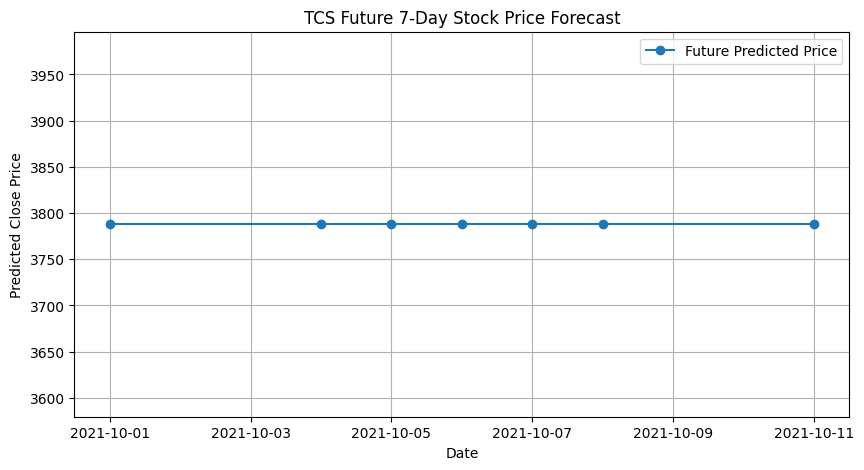

In [12]:
# ---------------- FUTURE 7 DAYS PRICE PREDICTION ----------------

# Retrain best XGBoost on full data
best_xgb.fit(X_scaled, y)

# Get last available row for future prediction base
last_row = X_scaled[-1].reshape(1, -1)

future_predictions = []
future_dates = []
last_date = data['Date'].iloc[-1]

for i in range(1, 8):  # Next 7 days
    next_pred = best_xgb.predict(last_row)[0]
    future_predictions.append(next_pred)

    # Generate next date (skip weekends)
    next_date = last_date + pd.tseries.offsets.BDay(i)
    future_dates.append(next_date)

    # Update last_row input with new predicted Close value
    new_row = last_row.copy()
    new_row[0][4] = next_pred  # updating Prev_Close feature
    last_row = new_row

# Create Future DataFrame
future_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Close': future_predictions
})

print("\n📈 Future 7-Day TCS Stock Price Prediction:")
print(future_df)

# Plot Future Forecast
plt.figure(figsize=(10,5))
plt.plot(future_df['Date'], future_df['Predicted_Close'], marker='o', label="Future Predicted Price")
plt.title("TCS Future 7-Day Stock Price Forecast")
plt.xlabel("Date")
plt.ylabel("Predicted Close Price")
plt.legend()
plt.grid(True)
plt.show()
